<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/Using_Pytorch_to_fight_cancer_(II).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Augmentation

### Setting our work environment

In [ ]:
!nvidia-smi

In [3]:
# Setting our $HOME to /content
import os
HOME = os.getcwd()
print(HOME)

/content


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
##  Loading a Dataset

# Create the dataset directory
import os
datasets_dir = os.path.join(HOME, "datasets")
os.makedirs(datasets_dir, exist_ok=True)
print(os.getcwd())

/content


In [5]:
# Change to new datsets folder and download the dataset
os.chdir(datasets_dir)
print('dataset_dir =', os.getcwd())
if  not os.path.isfile('exp0.zip'):
  !wget -q https://www.dropbox.com/s/7ir1jixrs1aw55n/exp0.zip
!unzip -qq -o exp0.zip

dataset_dir = /content/datasets


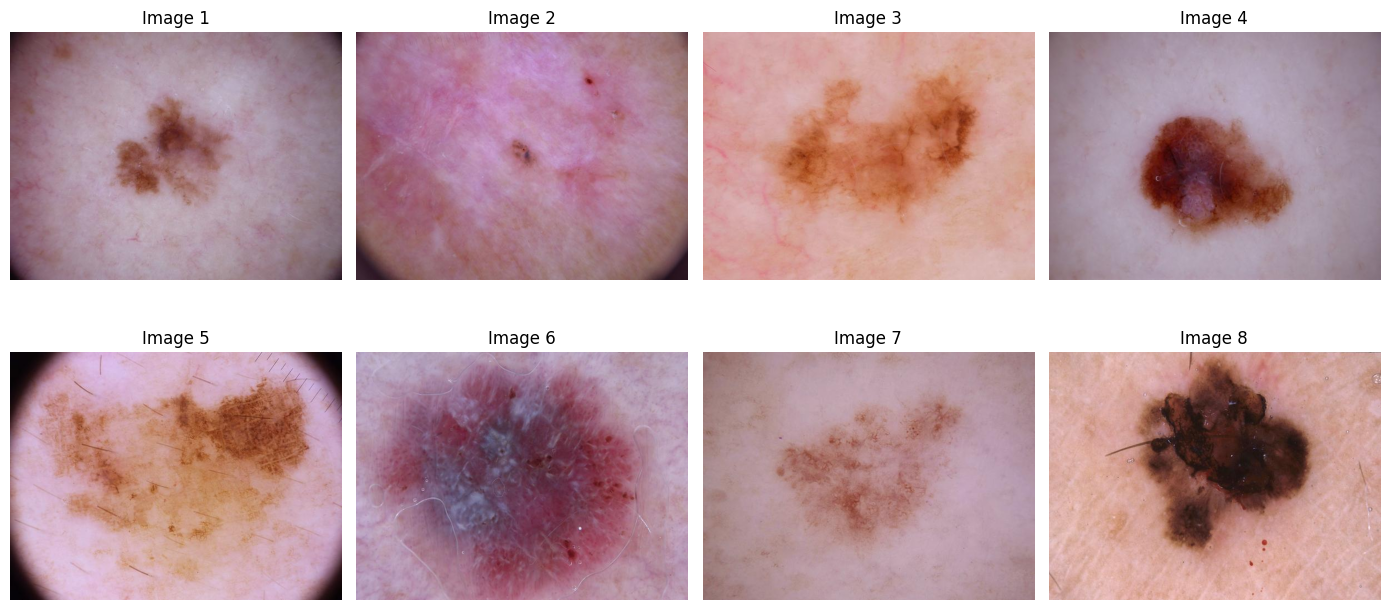


 Size of image:  (450, 600, 3)


In [6]:
# creates a figure with subplots arranged in a 2x4 grid
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg

# Directory of the images
image_directory = f'/content/datasets/exp0/test/class_1/'

# List of image paths
image_paths = glob.glob(image_directory + '*.jpg')[:8]

# Set up the figure with subplots
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

# Iterate through the images and display them in the subplots
for i, image_path in enumerate(image_paths):
    row = i // 4
    col = i % 4
    img = mpimg.imread(image_path)
    axs[row, col].imshow(img)
    axs[row, col].set_title(f'Image {i + 1}')
    axs[row, col].axis('off')

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()
print("\n Size of image: ", img.shape)

In [8]:
import torch
import torchvision
from torch.utils.data import DataLoader, ConcatDataset # CancatDataset is new
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import tqdm # progress bar

In [9]:
%%time

# 1. Calculate the mean and standard deviation on the training set.
# train, validation and test data directory

train_dir = "/content/datasets/exp0/train/"
val_dir  = "/content/datasets/exp0/test/"
test_dir   = "/content/datasets/exp0/val/"

# transform to calculate mean and standard desviation
transform = transforms.Compose([
    transforms.ToTensor()  # transform images to tensor
])

# Load the ImageFolder dataset and apply the transformation
dataset = datasets.ImageFolder(root= train_dir, transform=transform)

# it's better to use a loader to retrieve images (tensors)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize variables to store the sum of pixel values and
# standard deviation.
# These variables are set to floating-point zeros to ensure
# accurate calculations.
mean_sum = 0.0
std_sum = 0.0
total_samples = 0

# Iterates over the data loader (loader),
# calculates the mean and standard deviation across all channels
# for each batch(0) and spatial dimensions (height(2) and width(3))
for images, _ in loader:
    mean_sum += torch.mean(images, dim=[0, 2, 3])
    std_sum += torch.std(images, dim=[0, 2, 3])
    total_samples += 1

mean = mean_sum / total_samples
std = std_sum / total_samples

print("Total train samples:", total_samples)
print("Mean:", mean)
print("Std:", std)

Total train samples: 2700
Mean: tensor([0.7513, 0.5535, 0.5788])
Std: tensor([0.0921, 0.1196, 0.1349])


In [10]:
# Define the data transformations to be applied
# to each transformed dataset
transformations = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(128, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomPerspective(),
    #transforms.RandomErasing(p=0.5, scale=(1.0, 1.0), ratio=(1.0, 1.0),value='random'),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.2), ratio=(0.75, 1.33333333)),
]

# Add the ToTensor() and Normalize() transformation
# to each data transformation
for i in range(len(transformations)):
    transformations[i] = transforms.Compose([
        transformations[i],
        #transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

print(transformations)

[Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    RandomCrop(size=(128, 128), padding=4)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    RandomAffine(degrees=[-30.0, 30.0], translate=(0.1, 0.1), scale=(0.8, 1.2))
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
    ToTens

In [12]:
%time

# 2. Normalize the training set using these statistics.
train_dataset = datasets.ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

# 3. Normalize the test and validation set using the same statistics
# calculated on the training set.
val_set = datasets.ImageFolder(val_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

test_set = datasets.ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

print(f"Length of Train Data :{len(train_dataset)}")
print(f"Length of Validation Data : {len(val_set)}")
print(f"Length of Test Data : {len(test_set)}")

classes = train_dataset.classes
print('Classes: ', classes)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Length of Train Data :2700
Length of Validation Data : 600
Length of Test Data : 300
Classes:  ['class_0', 'class_1']


In [ ]:
# Aplicar cada transformación separada a un conjunto de datos transformado y concatenarlos
train_set = train_dataset
for transform in transformations:
    transformed_data = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
    train_set = ConcatDataset([train_dataset, transformed_data])
